# Glioma Tutorial − Radiomic Computations

@Author : [MEDomics consortium](https://github.com/medomics/)

@EMAIL : medomics.info@gmail.com

## Note:
Please Make sure you run & understand the [IBSI tests (4 IBSI-TUTO notebooks)](https://github.com/MahdiAll99/MEDimage/tree/main/IBSI-TESTs) before you run this notebook in order to have an idea on the processing and the computation processes. We also recommend that you take a look at the [MEDimage introduction notebook](https://github.com/MahdiAll99/MEDimage/tree/main/MEDimage-Tutorial) to understand the role of the *MEDimage* class in the package.

**STATEMENT**:
This file is part of <https://github.com/MEDomics/MEDomicsLab/>,
a package providing PYTHON programming tools for radiomics analysis.
--> Copyright (C) MEDomicsLab consortium.

This package is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This package is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this package.  If not, see <http://www.gnu.org/licenses/>.

## Introduction

This notebook is made to show how easy it is to use the *MEDimage* package to extract features from any image. So this notebook is a final tutorial that shows in a brief way the image processing and feature computation of a **[glioma TCGA](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga)** cancer patient/scan. The figure below shows the image processing scheme for feature calculation.

We will interpolate, re-segment and extract statistical & local intensity features.

<img src="https://ibsi.readthedocs.io/en/latest/_images/Processing_simplifiedv6.png" alt="Flowchart of radiomics study scheme" style="width:500px;"/>


## Dataset - Glioma TCGA MR image
In this notebook, feature computation is done using an MR image, which is provided in the dataset folder/repository.

Here are some information about our scan/patient:
 - **ID**: Glioma-TCGA-02-003
 - **Imaging scan name**: T1
 - **Modality**: MRscan
 - **Regions of interest**:
     - Number of regions: 3
     - Names of ROIs: ED, ET and NET
     - ROI name: {ED}+{ET}+{NET}

In [1]:
import argparse
import os
import pickle
import sys
from copy import deepcopy
from itertools import product
from json import dump, dumps
from pathlib import Path
import matplotlib.pyplot as plt

MODULE_DIR = os.path.dirname(os.path.abspath('../MEDimage/MEDimage.py'))
sys.path.append(os.path.dirname(MODULE_DIR))

import nibabel as nib
import numpy as np
from MEDimage.MEDimage import MEDimage
from MEDimage.MEDimageComputeRadiomics import MEDimageComputeRadiomics
from MEDimage.MEDimageProcessing import MEDimageProcessing
from MEDimage.utils import jsonUtils
from numpyencoder import NumpyEncoder

In [2]:
def __processParams(imParams, scanType):
    """
    Process the computation settings.
    
    Args:
        imParams (Dict): JSON with the options that will be used during 
            the image processing and features extraction.
        scanType (str): scan type (Ex: MRscan, CTscan...).
        
    Returns:
        A dict with all the settings for the right scan type.
        
    """
    # Find the right parameters for the given scan modality
    if scanType == 'MRscan':
        imParams = imParams['imParamMR']
    elif scanType == 'CTscan':
        imParams = imParams['imParamCT']
    elif scanType == 'PTscan':
        imParams = imParams['imParamPET']
    else:
        raise ValueError(r"scanType must be 'MRscan', 'PTscan' or 'CTscan'")
        
    return imParams

## Initialization

**PS**: Unlike the IBSI tests the JSON settings chosen here for the processing & features extraction are arbitrary, so feel free to change any of the setting in the JSON file.

In [3]:
pathData = Path(os.getcwd()) / "data" # Path to the data folder
pathSettings = Path(os.getcwd()) / "settings" # Path to the script settings
imParams = jsonUtils.loadjson(pathSettings / 'Extraction_Glioma.json') # load settings
nameRead = 'Glioma-TCGA-02-0003__T1.MRscan.npy' # scan file name
nameROI = '{ED}+{ET}+{NET}' # Region of interest name
roiType = ''
roiType_label = ''
imParams = __processParams(imParams, scanType='MRscan') # get the right params for out scan type

Now that we have all we need to instantiate a *MEDimage* class, we can finish the *MEDimage* initialization and start processing and extraction

In [4]:
from MEDimage.utils.initMEDimage import initMEDimage

MEDimageProcess, MEDimageCR = initMEDimage(nameRead, pathData, roiType, imParams, 'log_file_glioma_tuto.txt')

## Quick features extraction

As always, the first step is to create the ROI

In [5]:
from MEDimage.processing.getROI_fromIndexes import getROI_fromIndexes

volObjInit, roiObjInit = getROI_fromIndexes(MEDimageProcess, nameROI=nameROI, boxString='full')

- Interpolation

In [6]:
from MEDimage.processing.interpVolume import interpVolume

volObj = deepcopy(volObjInit)
roiObj_Morph = deepcopy(roiObjInit)

# Intensity Mask:
volObj = interpVolume(
    MEDimageCR,
    volObjS=volObjInit,
    voxDim=MEDimageCR.Params['scaleNonText'],
    interpMet=MEDimageCR.Params['volInterp'],
    roundVal=MEDimageCR.Params['glRound'],
    image_type='image',
    roiObjS=roiObjInit,
    boxString=MEDimageCR.Params['boxString']
)
# Morphological Mask:
roiObj_Morph = interpVolume(
    MEDimageCR,
    volObjS=roiObjInit,
    voxDim=MEDimageCR.Params['scaleNonText'],
    interpMet=MEDimageCR.Params['roiInterp'],
    roundVal=MEDimageCR.Params['roiPV'], 
    image_type='roi', 
    roiObjS=roiObjInit,
    boxString=MEDimageCR.Params['boxString']
)

- Re-segmentation (either outlier, range re-segmentation or both)

In [7]:
from MEDimage.processing.rangeReSeg import rangeReSeg

roiObj_Int = deepcopy(roiObj_Morph)
roiObj_Int.data = rangeReSeg(vol=volObj.data, 
                             roi=roiObj_Int.data,
                             im_range=MEDimageCR.Params['im_range'])

- ROI extraction

In [8]:
from MEDimage.processing.roiExtract import roiExtract

volInt_RE = roiExtract(
    vol=volObjInit.data, 
    roi=roiObjInit.data
)

- Statistical features extraction

In [9]:
from MEDimage.biomarkers.getStatsFeatures import getStatsFeatures

Stats = getStatsFeatures(
    vol=volInt_RE,
    intensity=MEDimageCR.Params['intensity']
)
Stats

{'Fstat_mean': 500.7649,
 'Fstat_var': 5551.7583,
 'Fstat_skew': 2.2217083753334506,
 'Fstat_kurt': 8.962973395157256,
 'Fstat_median': 494.0,
 'Fstat_min': 223.0,
 'Fstat_P10': 425.0,
 'Fstat_P90': 560.0,
 'Fstat_max': 1123.0,
 'Fstat_iqr': 72.0,
 'Fstat_range': 900.0,
 'Fstat_mad': 49.448166,
 'Fstat_rmad': 29.985937,
 'Fstat_medad': 49.128033,
 'Fstat_cov': 0.14879262,
 'Fstat_qcod': 0.07302231237322515,
 'Fstat_energy': 20293667000.0,
 'Fstat_rms': 506.2779}

- Local intensity features extraction

In [10]:
from MEDimage.biomarkers.getLocIntFeatures import getLocIntFeatures

LocalIntensity = getLocIntFeatures(
    imgObj=volObj.data, 
    roiObj=roiObj_Int.data,
    res=MEDimageCR.Params['scaleNonText'],
    intensity=MEDimageCR.Params['intensity']
)
LocalIntensity

{'Floc_peak_local': 496.42682, 'Floc_peak_global': []}

As you can see, the features extraction is pretty easy as long as you make sure to pass the right arguments to the right methods. In general, make sure you respect the order of the processing steps. For more fun, check the next part where we extract features from filtered images

## Extra - Features extraction from filtered image

In this section we are gonna filter our image (same scan) and use it to extract morphological features.

**PS**: Make sure the JSON settings file contains parameters for the filter you would like to use.

In [11]:
filterName = 'Laws' # make sure JSON setting file contains Laws filter params

Apply the filter on the original volume

In [12]:
VolObjInitOriginal = deepcopy(volObjInit)
VolObjInitFiltered = MEDimageProcess.applyFilter(filterName, VolObjInitOriginal)

Let's compare the original volume and the filtered one

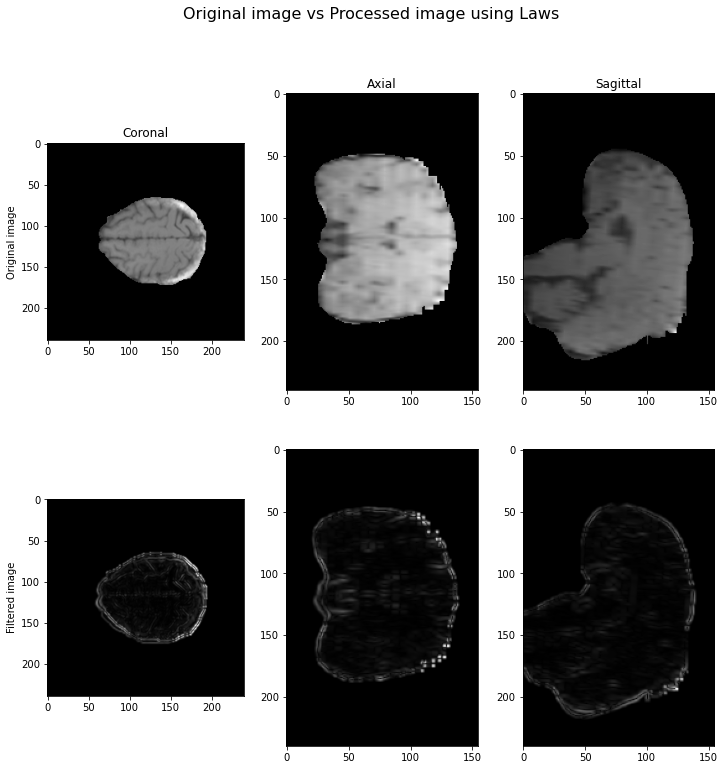

In [13]:
_slice = 120 # slice to plot

fig = plt.figure(figsize=(12, 12))
fig.suptitle(f'Original image vs Processed image using {filterName}', fontsize=16)

fig.add_subplot(2, 3, 1, ylabel="Original image", title="Coronal")
plt.imshow(volObjInit.data[:, :, _slice], cmap='gray')

fig.add_subplot(2, 3, 2, title="Axial")
plt.imshow(volObjInit.data[:, _slice, :], cmap='gray')

fig.add_subplot(2, 3, 3, title="Sagittal")
plt.imshow(volObjInit.data[_slice, :, :], cmap='gray')

fig.add_subplot(2, 3, 4, ylabel="Filtered image")
plt.imshow(VolObjInitFiltered.data[:, :, _slice], cmap='gray')

fig.add_subplot(2, 3, 5)
plt.imshow(VolObjInitFiltered.data[:, _slice, :], cmap='gray')

fig.add_subplot(2, 3, 6)
plt.imshow(VolObjInitFiltered.data[_slice, :, :], cmap='gray')

You can now process the filtered image or extract features from it the way you want

In [14]:
# Morph features extractions from filterd image without further processing
from MEDimage.biomarkers.getMorphFeatures import getMorphFeatures

MORPH = getMorphFeatures(
    vol=VolObjInitFiltered.data, 
    maskInt=roiObjInit.data, 
    maskMorph=roiObjInit.data,
    res=MEDimageCR.Params['scaleNonText'],
    intensity=MEDimageCR.Params['intensity']
)
MORPH

{'Fmorph_vol': 632229.0,
 'Fmorph_approx_vol': 633392.0,
 'Fmorph_area': 73211.26058000134,
 'Fmorph_av': 0.11579864349784863,
 'Fmorph_comp_1': 0.018006638645877735,
 'Fmorph_comp_2': 0.11520399636111579,
 'Fmorph_sph_dispr': 2.055152964029961,
 'Fmorph_sphericity': 0.48658178612607716,
 'Fmorph_asphericity': 1.0551529640299595,
 'Fmorph_com': 25.068015642912293,
 'Fmorph_diam': 241.43736247731005,
 'Fmorph_pca_major': 184.04023285379049,
 'Fmorph_pca_minor': 104.0043753289742,
 'Fmorph_pca_least': 71.9777716962052,
 'Fmorph_pca_elongation': 0.5651176034514136,
 'Fmorph_pca_flatness': 0.3910980255789365,
 'Fmorph_v_dens_aabb': 0.2056580364949827,
 'Fmorph_a_dens_aabb': 0.5424342109240808,
 'Fmorph_v_dens_ombb': 0.21543412498277215,
 'Fmorph_a_dens_ombb': 0.5587646620143069,
 'Fmorph_v_dens_aee': 0.8764214718470545,
 'Fmorph_a_dens_aee': 1.7878198952442472,
 'Fmorph_v_dens_mvee': 0.13769404162063306,
 'Fmorph_a_dens_mvee': 0.4895027948575469,
 'Fmorph_v_dens_conv_hull': 0.5147134090180

## Image & Mask cropping - Box creation

In this last section we will demonstrate how you can crop the image & the mask and generate a bounding box around the ROI with a specific cropping shape. This can be done using the method *cropBox()* in the processing sub-module. 

Visualize imaging data before cropping

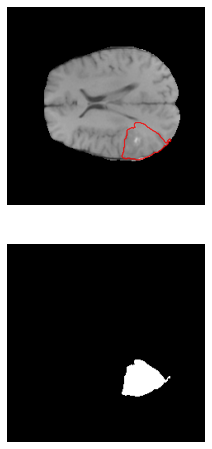

In [15]:
_slice = 80 # index of slice that will be plotted
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.axis('off')
plt.imshow(volObjInit.data[:, :, _slice], cmap='gray')
plt.contour(roiObjInit.data[:, :, _slice], colors='red', linewidths=0.4, origin='lower', alpha=0.5)
plt.subplot(2, 1, 2)
plt.axis('off')
plt.imshow(roiObjInit.data[:, :, _slice], cmap='gray')
plt.show()

Let's now specify the cropping shape and call the cropping method

In [44]:
from MEDimage.processing.cropBox import cropBox

# crop the initial imaging data
crop_shape = [144, 112, 72] # All elements of crop_shape must be an even number (in voxels not mm)
new_image, new_roi = cropBox(volObjInit.data, roiObjInit.data, crop_shape)

Visualize imaging data after cropping

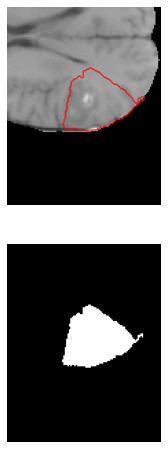

In [45]:
_slice = 39 # index of slice that will be plotted
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.axis('off')
plt.imshow(new_image[:, :, _slice], cmap='gray')
plt.contour(new_roi[:, :, _slice], colors='red', linewidths=0.4, origin='lower', alpha=0.5)
plt.subplot(2, 1, 2)
plt.axis('off')
plt.imshow(new_roi[:, :, _slice], cmap='gray')
plt.show()

## Bonus: Use the created box to compute radiomics

The created box can serve as good as the full image volume, as long as our ROI is included in the imaging data. without processing, let's try to extract some basic features

Update the imaging data with the new cropped data

In [46]:
volObjInit.data = new_image
roiObjInit.data = new_roi

Extract Morphological features

In [47]:
newMORPH = getMorphFeatures(
    vol=volObjInit.data, 
    maskInt=roiObjInit.data, 
    maskMorph=roiObjInit.data,
    res=MEDimageCR.Params['scaleNonText'],
    intensity=MEDimageCR.Params['intensity']
)
newMORPH

{'Fmorph_vol': 616271.6666666666,
 'Fmorph_approx_vol': 617304.0,
 'Fmorph_area': 69139.28532330731,
 'Fmorph_av': 0.1121896219848508,
 'Fmorph_comp_1': 0.019125373970351116,
 'Fmorph_comp_2': 0.12996371527489586,
 'Fmorph_sph_dispr': 1.9742067266050645,
 'Fmorph_sphericity': 0.5065325664853981,
 'Fmorph_asphericity': 0.9742067266050629,
 'Fmorph_com': 3.484590452386955,
 'Fmorph_diam': 224.51725991557976,
 'Fmorph_pca_major': 173.32465256246604,
 'Fmorph_pca_minor': 102.2556139940219,
 'Fmorph_pca_least': 72.27308822941241,
 'Fmorph_pca_elongation': 0.589965780875684,
 'Fmorph_pca_flatness': 0.4169810073807317,
 'Fmorph_v_dens_aabb': 0.24833642273801848,
 'Fmorph_a_dens_aabb': 0.6000840623117215,
 'Fmorph_v_dens_ombb': 0.25228844903390446,
 'Fmorph_a_dens_ombb': 0.6032582949233013,
 'Fmorph_v_dens_aee': 0.9188602565670848,
 'Fmorph_a_dens_aee': 1.787223779508302,
 'Fmorph_v_dens_mvee': 0.15869478968689874,
 'Fmorph_a_dens_mvee': 0.5488232284835646,
 'Fmorph_v_dens_conv_hull': 0.546182

Extract Local intensity features

In [48]:
NewLocalIntensity = getLocIntFeatures(
    imgObj=volObjInit.data, 
    roiObj=roiObjInit.data,
    res=MEDimageCR.Params['scaleNonText'],
    intensity=MEDimageCR.Params['intensity']
)
NewLocalIntensity

{'Floc_peak_local': 842.6733, 'Floc_peak_global': []}

## Conclusion

This final tutorial shows how the *MEDimage package* is an easy & useful tool for reproducible image processing and features extraction. It has also been standardised with the [IBSI](https://theibsi.github.io/) norms which makes it a reference standard package for radiomics analysis.